In [64]:
import pandas as pd
import numpy as np
import seaborn as sns

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from keras import layers, losses
from sklearn.model_selection import train_test_split
from keras.models import Model

import warnings
warnings.filterwarnings('ignore')


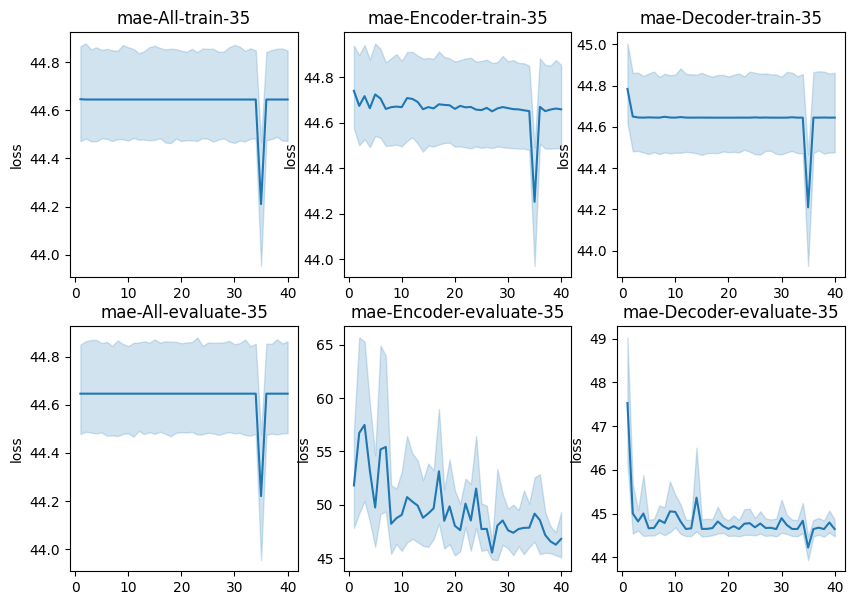

In [81]:
f, axs= plt.subplots(2, 3, figsize = (10,7))
models = ['All', 'Encoder', 'Decoder', 'All', 'Encoder', 'Decoder']
loss= 'mae'
for i, model in enumerate(models):
    train_evaluate = 'train'
    l = 0
    c = i
    if i>2:
        train_evaluate = 'evaluate'
        l = 1
        c = i-3
    data = pd.read_csv(f'/home/gabrieltalasso/IoT_Anomaly_Detection/logs/SKAB/CNN/{train_evaluate}/loss_{loss}_{model}.csv', names = ['cid', 'round', 'loss'])
    sns.lineplot(data = data, x = 'round', y = 'loss', ax = axs[l][c])
    axs[l][c].set_title(f'{loss}-{model}-{train_evaluate}-35')
    axs[l][c].set_xlabel('')

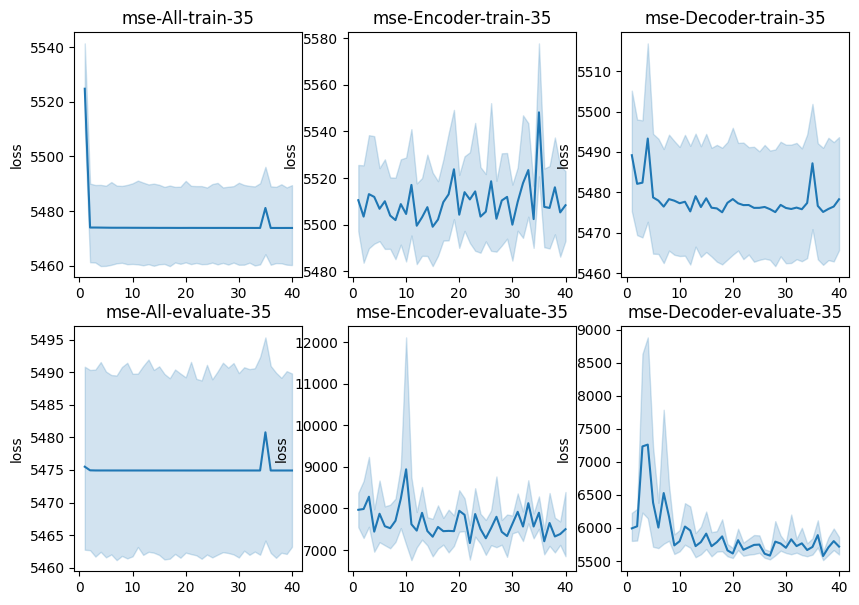

In [80]:
f, axs= plt.subplots(2, 3, figsize = (10,7))
models = ['All', 'Encoder', 'Decoder', 'All', 'Encoder', 'Decoder']
loss= 'mse'
for i, model in enumerate(models):
    train_evaluate = 'train'
    l = 0
    c = i
    if i>2:
        train_evaluate = 'evaluate'
        l = 1
        c = i-3
    data = pd.read_csv(f'/home/gabrieltalasso/IoT_Anomaly_Detection/logs/SKAB/CNN/{train_evaluate}/loss_{loss}_{model}.csv', names = ['cid', 'round', 'loss'])
    sns.lineplot(data = data, x = 'round', y = 'loss', ax = axs[l][c])
    axs[l][c].set_title(f'{loss}-{model}-{train_evaluate}-35')
    axs[l][c].set_xlabel('')
    

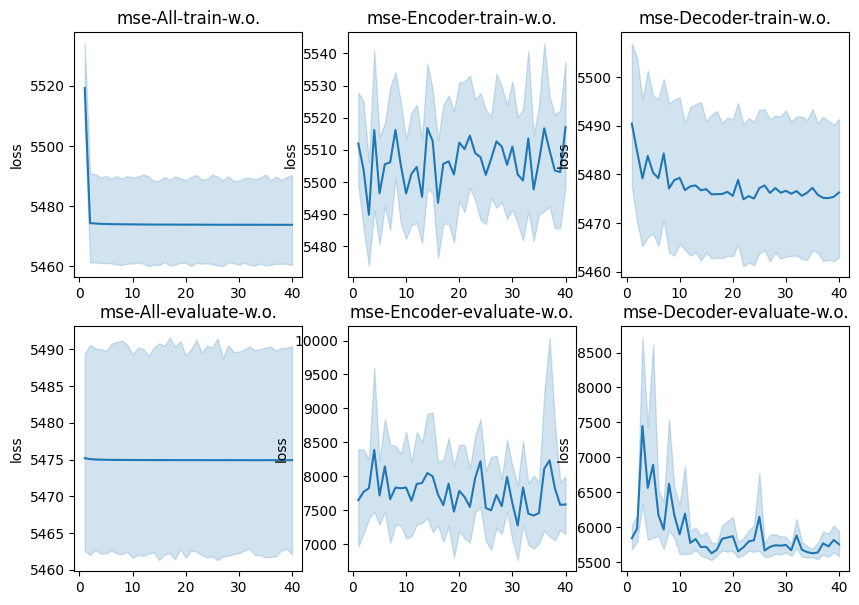

In [67]:
f, axs= plt.subplots(2, 3, figsize = (10,7))
models = ['All', 'Encoder', 'Decoder', 'All', 'Encoder', 'Decoder']
loss= 'mse'
for i, model in enumerate(models):
    train_evaluate = 'train'
    l = 0
    c = i
    if i>2:
        train_evaluate = 'evaluate'
        l = 1
        c = i-3
    data = pd.read_csv(f'/home/gabrieltalasso/IoT_Anomaly_Detection/logs/SKAB/CNN/wo_anomaly/{train_evaluate}/loss_{loss}_{model}.csv', names = ['cid', 'round', 'loss'])
    sns.lineplot(data, x = 'round', y = 'loss', ax = axs[l][c])
    axs[l][c].set_title(f'{loss}-{model}-{train_evaluate}-w.o.')
    axs[l][c].set_xlabel('')

<AxesSubplot:xlabel='round', ylabel='loss'>

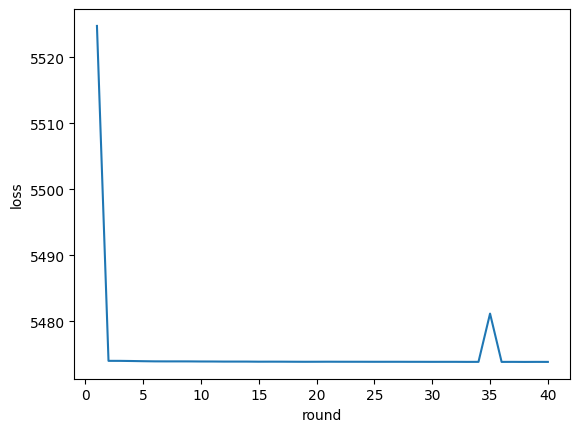

In [68]:
data = pd.read_csv('/home/gabrieltalasso/IoT_Anomaly_Detection/logs/SKAB/CNN/train/loss_mse_All.csv', names = ['cid', 'round', 'loss'])
sns.lineplot(data = data.groupby('round').mean(), x = 'round', y = 'loss')

<AxesSubplot:xlabel='round', ylabel='loss'>

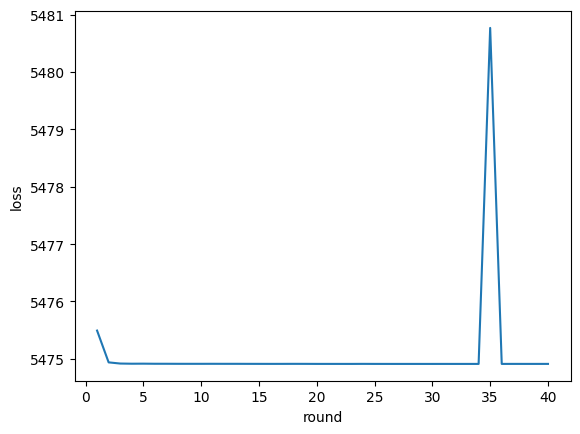

In [69]:
data = pd.read_csv('/home/gabrieltalasso/IoT_Anomaly_Detection/logs/SKAB/CNN/evaluate/loss_mse_All.csv', names = ['cid', 'round', 'loss'])
sns.lineplot(data = data.groupby('round').mean(), x = 'round', y = 'loss')

<AxesSubplot:xlabel='round', ylabel='loss'>

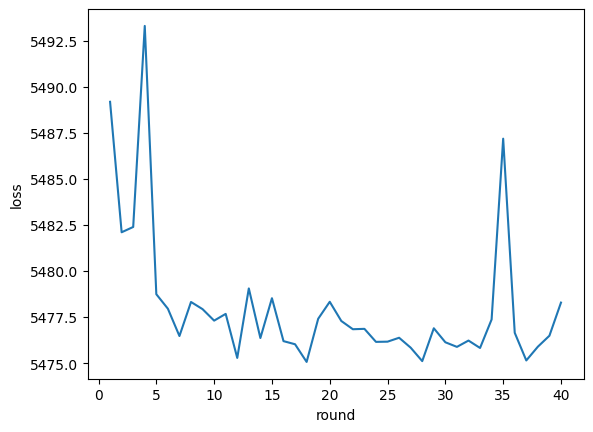

In [70]:
data = pd.read_csv('/home/gabrieltalasso/IoT_Anomaly_Detection/logs/SKAB/CNN/train/loss_mse_Decoder.csv', names = ['cid', 'round', 'loss'])
sns.lineplot(data = data.groupby('round').mean(), x = 'round', y = 'loss')

<AxesSubplot:xlabel='round', ylabel='loss'>

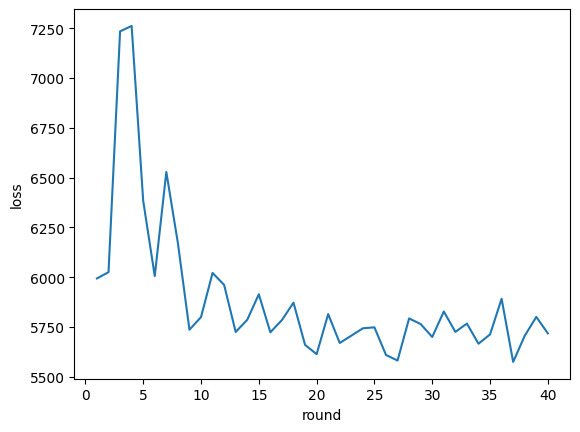

In [71]:
data = pd.read_csv('/home/gabrieltalasso/IoT_Anomaly_Detection/logs/SKAB/CNN/evaluate/loss_mse_Decoder.csv', names = ['cid', 'round', 'loss'])
sns.lineplot(data = data.groupby('round').mean(), x = 'round', y = 'loss')

<AxesSubplot:xlabel='round', ylabel='loss'>

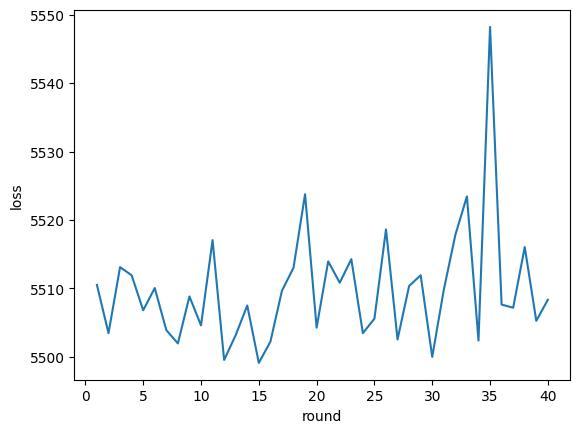

In [72]:
data = pd.read_csv('/home/gabrieltalasso/IoT_Anomaly_Detection/logs/SKAB/CNN/train/loss_mse_Encoder.csv', names = ['cid', 'round', 'loss'])
sns.lineplot(data = data.groupby('round').mean(), x = 'round', y = 'loss')

<AxesSubplot:xlabel='round', ylabel='loss'>

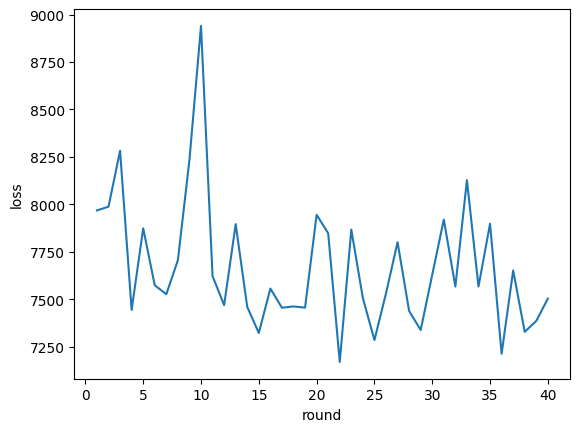

In [73]:
data = pd.read_csv('/home/gabrieltalasso/IoT_Anomaly_Detection/logs/SKAB/CNN/evaluate/loss_mse_Encoder.csv', names = ['cid', 'round', 'loss'])
sns.lineplot(data = data.groupby('round').mean(), x = 'round', y = 'loss')

<AxesSubplot:xlabel='round', ylabel='loss'>

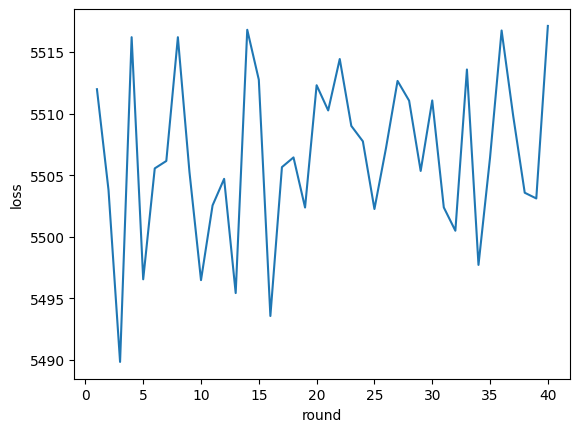

In [74]:
data = pd.read_csv('/home/gabrieltalasso/IoT_Anomaly_Detection/logs/SKAB/CNN/wo_anomaly/train/loss_mse_Encoder.csv', names = ['cid', 'round', 'loss'])
sns.lineplot(data = data.groupby('round').mean(), x = 'round', y = 'loss')

<AxesSubplot:xlabel='round', ylabel='loss'>

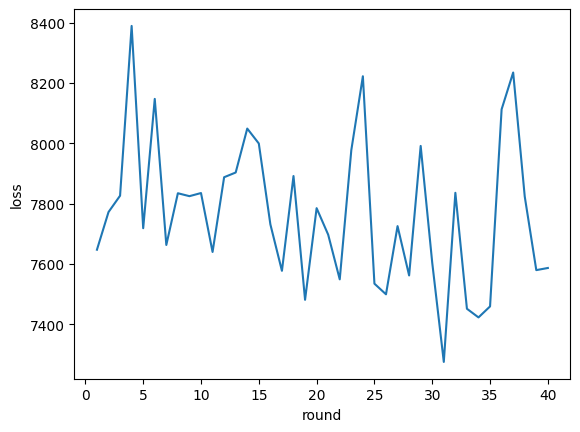

In [75]:
data = pd.read_csv('/home/gabrieltalasso/IoT_Anomaly_Detection/logs/SKAB/CNN/wo_anomaly/evaluate/loss_mse_Encoder.csv', names = ['cid', 'round', 'loss'])
sns.lineplot(data = data.groupby('round').mean(), x = 'round', y = 'loss')